# Pytorchの機能を用いて、[プログラム](https://drive.google.com/drive/folders/1rhAvafqIOYjZNGtc0bE0bsWPkIbXFb51?usp=sharing)をリファクタリングせよ。

## 1. [Autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)を用いて、勾配を計算し、重みを更新せよ。reg_1.pyを参照。

用いるモジュール： [requires_grad](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html); [requires_grad_](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html); [backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html); [grad](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html); [no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html).

## 2. nnを用いて、モデルと損失関数を定義せよ。reg_2.pyを参照。

用いるモジュール： [nn](https://pytorch.org/docs/stable/nn.html); [Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential); [Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear); [ReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU); [MSELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss); [parameters](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.parameters)

## 3. optimizerを用いて、パラメータを更新せよ。reg_3.pyを参照。

用いるモジュール： [optim](https://pytorch.org/docs/stable/optim.html); [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD); [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam); [zero_grad](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer.zero_grad); [step](https://pytorch.org/docs/stable/optim.html#optimizer-step)

## 4. 練習問題

1. 10層の全結合層のモデル（D_in->H, H->H, H->H, ..., H->D_out）を用いたプログラムを作成せよ。
2. 100層の全結合層のモデル（D_in->H, H->H, H->H, ..., H->D_out）を用いたプログラムを作成せよ。
3. cls.pyをリファクタリングせよ。

ヒント：

- モデルを作る方法は様々である。[containers](https://pytorch.org/docs/stable/nn.html#containers)
- softmaxとCrossEntorpyLossはモジュールを使っても良い。[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss); [functional.cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy);

# reg.py

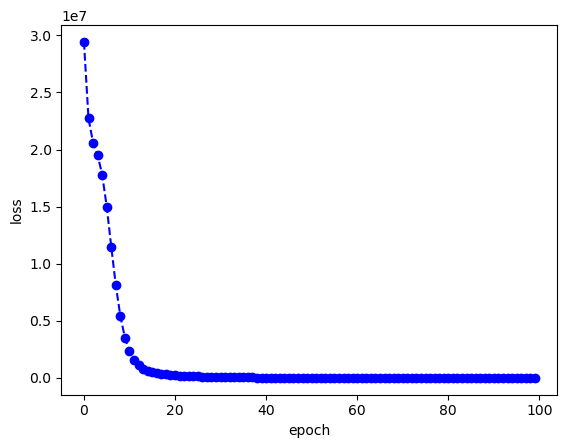

In [4]:
# Regression task
# manual_seed: 再現性を担保するための乱数固定
# matmul: 2次元x3次元とかもいい感じに掛け合わせてくれる. ブロードキャスト.
# clamp: テンソルが範囲外の時、最大値や最小値に置き換える
# transpose: テンソルの次元の入れ替え



from torch import manual_seed, matmul, clamp, square, \
    transpose, randn, clone, zeros, no_grad, Tensor
import matplotlib.pyplot as plt

def draw_losses( history_losses:list ):
    fig, ax = plt.subplots()
    ax.plot( history_losses, color='blue', marker='o', linestyle='dashed' )
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    fig.show()


def training( xin:Tensor, ygt:Tensor, w1:Tensor, w2:Tensor, \
              epochs:int=100, learning_rate:float=1e-6) -> list:
    history_losses = zeros( epochs )

    for i in range( epochs ):

        # Forward pass: compute predicted y
        y1 = matmul( xin, w1 )
        y2 = clamp( y1, 0)
        y3 = matmul( y2, w2 )  # (N,H) * (H,D_out) = (N,D_out)

        # Square loss
        loss = square( y3 - ygt ).sum()
        history_losses[i] = loss
        #print(loss)

        # Backprop to compute gradients of w1 and w2 with respect to loss
        grad_y3 = 2.0 * ( y3 - ygt )
        grad_w2 = matmul( transpose(y2,0,1), grad_y3 )
        grad_y2 = matmul( grad_y3, transpose(w2,0,1) )
        grad_y1 = clone( grad_y2 )
        grad_y1[y1 < 0] = 0
        grad_w1 = matmul( transpose(xin,0,1), grad_y1 )

        # Update weights
        w1 -= learning_rate * grad_w1
        w2 -= learning_rate * grad_w2

    return history_losses.tolist()


if __name__ == '__main__':

    epochs = 100
    N = 64       # Batch size
    D_in = 1000  # Input dimension
    H = 100      # Hidden dimension
    D_out = 10   # Output dimension
    learning_rate = 1e-6

    manual_seed(0)  # Reproducibility
    xin = randn(N, D_in)   # Input
    ygt = randn(N, D_out)  # Ground truth

    # Randomly initialize weights
    w1 = randn(D_in, H)
    w2 = randn(H, D_out)

    # Training
    history_losses = training( xin, ygt, w1, w2, epochs, learning_rate )

    # Plot
    draw_losses( history_losses )
    breakpoint()

# reg_1.py

Epoch 0, Loss 29428666.000000
Epoch 10, Loss 2315861.500000
Epoch 20, Loss 232998.640625
Epoch 30, Loss 75053.398438
Epoch 40, Loss 29303.423828
Epoch 50, Loss 12694.033203
Epoch 60, Loss 5884.146484
Epoch 70, Loss 2864.861328
Epoch 80, Loss 1448.980957
Epoch 90, Loss 754.581604


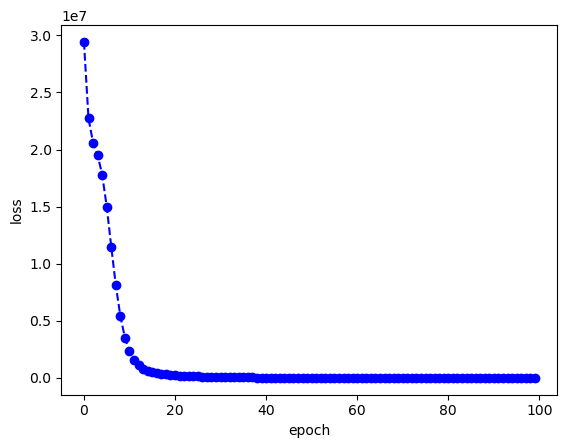

In [9]:
# Regression task
#用いるモジュール： requires_grad, requires_grad_, backward, grad, no_grad

from torch import manual_seed, matmul, clamp, square, \
    transpose, randn, clone, zeros, no_grad, Tensor
import matplotlib.pyplot as plt

def draw_losses( history_losses:list ):
    fig, ax = plt.subplots()
    ax.plot( history_losses, color='blue', marker='o', linestyle='dashed' )
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    fig.show()


def training( xin:Tensor, ygt:Tensor, w1:Tensor, w2:Tensor, \
              epochs:int=100, learning_rate:float=1e-6) -> list:
    history_losses = zeros( epochs )
    #print("history_losses:", history_losses.shape)
    #print("xin: ", xin.shape)
    #print("w1: ", w1.shape)
    #print("w2: ", w2.shape)
    #print("ygt: ", ygt.shape)

    for i in range( epochs ):


        w1.requires_grad = True
        w2.requires_grad = True #ここの宣言大事
        # Forward pass: compute predicted
        y = matmul( clamp( matmul(xin, w1), 0), w2) 
        #print("y; ", y.shape)

        # Square loss
        loss = square( y - ygt ).sum() #ここを例えば.averageにすると損失の遷移が直線的になる
        #print(loss)
        #print("loss: ", loss.shape)
        #print(loss)
        history_losses[i] = loss

        # Backward
        loss.backward()
        #if i == 20: print(w1.grad)

        # Update weights
        with no_grad():
            """ withブロック内でpytorchのautogradメカニズムを無効化している、
            つまり順伝搬のグラフにエッジを追加しないようにしている(らしい)"""
            #print("learning_rate: ", learning_rate)
            #print("w1.grad: ", w1.grad.shape)            
            #print("w1.grad: ", w1.grad)
            w1 -= learning_rate * w1.grad
            w2 -= learning_rate * w2.grad

            # Zero the gradients
            w1.grad.zero_()
            w2.grad.zero_()

        if i % 10 == 0: print('Epoch %d, Loss %f' % (i, float(loss)))

    #print ("w1: ", w1)

    return history_losses.tolist()


if __name__ == '__main__':

    epochs = 100
    N = 64       # Batch size
    D_in = 1000  # Input dimension
    H = 100      # Hidden dimension
    D_out = 10   # Output dimension
    learning_rate = 1e-6

    manual_seed(0)  # Reproducibility
    xin = randn(N, D_in)   # Input
    ygt = randn(N, D_out)  # Ground truth

    # Randomly initialize weights
    w1 = randn(D_in, H)
    w2 = randn(H, D_out)

    # Training
    history_losses = training( xin, ygt, w1, w2, epochs, learning_rate )

    # Plot
    draw_losses( history_losses )
    breakpoint()

# reg_2.py

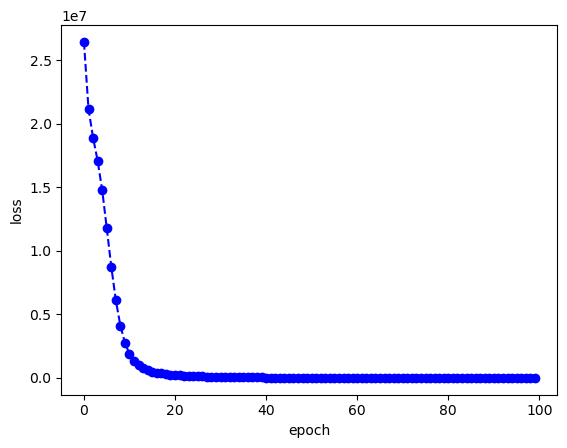

In [8]:
# Regression task
# 用いるモジュール： nn, Sequential, Linear, ReLU, MSELoss, parameters

from torch import manual_seed, matmul, clamp, square, \
    transpose, randn, clone, zeros, no_grad, Tensor
import matplotlib.pyplot as plt

import torch.nn as nn

def draw_losses( history_losses:list ):
    fig, ax = plt.subplots()
    ax.plot( history_losses, color='blue', marker='o', linestyle='dashed' )
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    fig.show()


"""#前回
def training( xin:Tensor, ygt:Tensor, w1:Tensor, w2:Tensor, \
              epochs:int=100, learning_rate:float=1e-6) -> list:"""

def training( xin:Tensor, ygt:Tensor, model, loss_func, \
             epochs:int=100, learning_rate:float=1e-6) -> list:
    
    history_losses = zeros( epochs )

    for i in range( epochs ):

        # Forward pass: compute predicted y
        y = model(xin)

        # Square loss
        loss = loss_func(y, ygt)
        history_losses[i] = loss



        # Backward
        loss.backward()

        # Update weights
        with no_grad():
            for i in [0,2]:
                model[i].weight -= learning_rate * model[i].weight.grad
                #model[i].bias -= learning_rate * model[i].bias.grad

                # Zero the gradients
                model[i].weight.grad.zero_()
                #model[i].bias.grad.zero_()

            """for i in range(2):
                model[i] -= learning_rate * model[i].grad

                # Zero the gradients
                model[i].grad.zero_()"""

        if i % 10 == 0: print('Epoch %d, Loss %f' % (i, float(loss)))
        


    return history_losses.tolist()



#今までのコードは乱数で初期重みを設定していた. 
#損失の遷移が同じ挙動するよう機能を追加
def init_weights(m):
    "重みを標準正規分布で初期化する"
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight)



if __name__ == '__main__':

    epochs = 100
    N = 64       # Batch size
    D_in = 1000  # Input dimension
    H = 100      # Hidden dimension
    D_out = 10   # Output dimension
    learning_rate = 1e-6

    manual_seed(0)  # Reproducibility
    xin = randn(N, D_in)   # Input
    ygt = randn(N, D_out)  # Ground truth

    # Model
    model = nn.Sequential(
            nn.Linear(D_in, H, bias = False),
            nn.ReLU(),
            nn.Linear(H, D_out, bias = False)
    )
    model.apply(init_weights)

    # Loss function
    loss_func = nn.MSELoss(reduction='sum') #sumは今までと条件揃えるため

    # Training
    history_losses = training( xin, ygt, model, loss_func, epochs, learning_rate )
    #print("w1")
    #for param in model[0].parameters():
        #print(param)
    #print("w2")
    #for param in model[2].parameters():
        #print(param)
    

    # Plot
    draw_losses( history_losses )
    breakpoint()

# reg_3.py

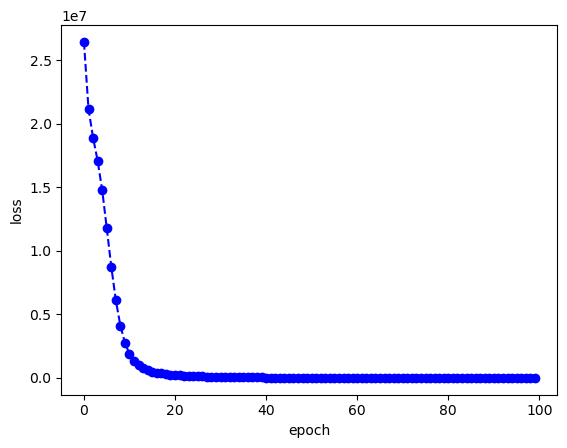

In [ ]:
# Regression task
# 用いるモジュール： optim, SGD, Adam, zero_grad, step

from torch import manual_seed, matmul, clamp, square, \
    transpose, randn, clone, zeros, no_grad, Tensor
import matplotlib.pyplot as plt

import torch.nn as nn  # nn
import torch.optim as optim  # optim


def draw_losses( history_losses:list ):
    fig, ax = plt.subplots()
    ax.plot( history_losses, color='blue', marker='o', linestyle='dashed' )
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    fig.show()


def training(  xin:Tensor, ygt:Tensor, model, loss_func, optimizer, epochs):
    history_losses = zeros( epochs )

    for i in range( epochs ):

        # Forward pass: compute predicted y
        y = model(xin)

        # Square loss
        loss = loss_func(y, ygt)
        history_losses[i] = loss

        # Backward
        loss.backward()

        # Update weights
        optimizer.step()
        optimizer.zero_grad()

    return history_losses.tolist()


def init_weights(m):
    "重みを標準正規分布で初期化する"
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight)

if __name__ == '__main__':

    epochs = 100
    N = 64       # Batch size
    D_in = 1000  # Input dimension
    H = 100      # Hidden dimension
    D_out = 10   # Output dimension
    learning_rate = 1e-6

    manual_seed(0)  # Reproducibility
    xin = randn(N, D_in)   # Input
    ygt = randn(N, D_out)  # Ground truth

    # Model
    model = nn.Sequential(
            nn.Linear(D_in, H, bias = False),
            nn.ReLU(),
            nn.Linear(H, D_out, bias = False)
    )
    model.apply(init_weights)
    #optimizer = optim.SGD( [w1, w2], lr=learning_rate)
    optimizer = optim.SGD( model.parameters(), lr=learning_rate)

    # Loss function
    loss_func = nn.MSELoss(reduction='sum')

    # Training
    history_losses = training( xin, ygt, model, loss_func, optimizer, epochs )

    # Plot
    draw_losses( history_losses )
    breakpoint()

# cls.py

In [1]:
# Classification task
import torch
from torch import matmul, clamp, transpose

torch.manual_seed(0)  # Reproducibility

N = 64       # Batch size
D_in = 1000  # Input dimension
H = 100      # Hidden dimension
D_out = 10   # Output dimension
learning_rate = 1e-4
xin = torch.randn(N, D_in)   # Input

# Ground truth
igt = torch.randint( 0, D_out-1, (N,) )  # Class indices
ygt = torch.zeros( N, D_out )
ygt[ range(N), igt ] = 1  # One-hot vector

# Randomly initialize weights
w1 = torch.randn(D_in, H)
w2 = torch.randn(H, D_out)

for i in range(500):

    # Forward pass: compute predicted y
    y1 = matmul( xin, w1 )
    y2 = clamp( y1, min=0 )
    y3 = matmul( y1, yy2 )  # (N,H) * (H,D_out) = (N,D_out)

    # Calculate cross entropy loss
    ## Apply Softmax
    m, _ = y3.max(axis=1,keepdims=True)
    _y3 = (y3 - m).exp()  # For avoiding inf
    y3_softmax = _y3 / _y3.sum(axis=1, keepdims=True)  # Predicted values

    ## Negative log likelihood
    _y = y3_softmax[ range(N), igt ]
    _y[ _y==0.0 ] = 1e-10  # For avoiding inf
    loss = - _y.log().sum()
    print( f'epoch={i:3d}, loss={float(loss) : f}' )

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y3 = y3_softmax.clone()
    grad_y3[ range(N), igt ] -= 1.0
    grad_w2 = matmul( transpose(y2,0,1), grad_y3 )
    grad_y2 = matmul( grad_y3, transpose(w2,0,1) )
    grad_y1 = grad_y2.clone()
    grad_y1[y1 < 0] = 0
    grad_w1 = matmul( transpose(xin,0,1),  grad_y1 )

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

epoch=  0, loss= 1525.344971
epoch=  1, loss= 1518.247925
epoch=  2, loss= 1568.744995
epoch=  3, loss= 1459.769165
epoch=  4, loss= 1348.280518
epoch=  5, loss= 1314.823242
epoch=  6, loss= 1220.472900
epoch=  7, loss= 1217.744873
epoch=  8, loss= 1171.689331
epoch=  9, loss= 1369.214233
epoch= 10, loss= 1387.256470
epoch= 11, loss= 1317.924072
epoch= 12, loss= 1250.573730
epoch= 13, loss= 1254.563721
epoch= 14, loss= 1395.125488
epoch= 15, loss= 1334.756592
epoch= 16, loss= 1282.424316
epoch= 17, loss= 1244.411865
epoch= 18, loss= 1289.757202
epoch= 19, loss= 1283.916626
epoch= 20, loss= 1280.487061
epoch= 21, loss= 1337.325928
epoch= 22, loss= 1364.091919
epoch= 23, loss= 1236.847412
epoch= 24, loss= 1120.431030
epoch= 25, loss= 1061.781860
epoch= 26, loss= 943.214966
epoch= 27, loss= 898.878296
epoch= 28, loss= 819.472290
epoch= 29, loss= 755.006226
epoch= 30, loss= 715.706665
epoch= 31, loss= 679.672363
epoch= 32, loss= 861.463257
epoch= 33, loss= 864.816650
epoch= 34, loss= 798.1